In [1]:
import os
import sys
path = "D:\qml\edm_key_files\eqgnn"
directory = path
os.chdir(directory)
sys.path.append(os.path.abspath("D:\qml\edm_key_files\eqgnn"))
print(os.getcwd())

D:\qml\edm_key_files\eqgnn


In [3]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import scipy
import networkx as nx
import copy
import random

# from numpy.random import default_rng
import pandas as pd
from tqdm import tqdm
from time import time
import os
import copy
from particle import Particle
# from sklearn.model_selection import train_test_split
from preprocess import *

import torch
from torch import nn as nn
# from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.nn import Linear
import torch.nn.functional as F
from scipy import stats
from sklearn.metrics import roc_curve, roc_auc_score


from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, InMemoryDataset, download_url
# from torch_geometric.nn import GCNConv
# from torch_geometric.nn import GATConv
# from torch_geometric.nn import Sequential
# from torch_geometric import nn
# from torch_geometric.nn import global_mean_pool


torch.set_default_dtype(torch.float64)
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Device: ',device)

np.random.seed(0)
torch.manual_seed(0)

Device:  cuda


In [5]:
path = 'data/'
plot_path = 'plots/'

In [6]:
N=100
x10_sorted_12500 = np.load(path+'train_wt_h.npy')[:N]
y10_sorted_12500 = np.load(path+'random_train_labels.npy')[:N]

In [8]:
def preprocess_molecular_data_quantum(x_data, y_data, nodes_per_graph=3):
    """
    预处理分子图数据并生成量子哈密顿量。
    
    参数:
        x_data (np.ndarray): 分子图数据，形状为 (num_molecules, 9, 4)。
        y_data (np.ndarray): 分子标签，形状为 (num_molecules,)。
        nodes_per_graph (int): 每个分子图中使用的最大节点数。
    
    返回:
        x_data (torch.Tensor): 处理后的分子图数据。
        y_data (torch.Tensor): 分子标签。
        edge_tensor (torch.Tensor): 边张量。
        edge_indx_tensor (torch.Tensor): 边索引张量。
        edge_attr_matrix (torch.Tensor): 边属性矩阵。
        graph_help (torch.Tensor): 辅助图信息。
        quantum_hamiltonians (torch.Tensor): 量子哈密顿量。
    """
    print('--- Preprocessing Molecular Data ---')
    x_data = torch.tensor(x_data, dtype=torch.float32)
    y_data = torch.tensor(y_data, dtype=torch.float32)

    x_data_max = x_data.max(dim=1).values.max(dim=0).values
    x_data = x_data / x_data_max

    print()
    print('--- Calculating Edge Tensors ---')
    N = x_data.shape[0]
    M = nodes_per_graph
    connections = nodes_per_graph

    edge_tensor = torch.zeros((N, M, M), dtype=torch.float32)
    edge_indx_tensor = torch.zeros((N, 2, connections * (connections - 1)), dtype=torch.int32)
    edge_attr_matrix = torch.zeros((N, connections * (connections - 1), 1), dtype=torch.float32)

    for mol in tqdm(range(N)):
        positions = x_data[mol, :M, :3]
        dist_matrix = torch.cdist(positions, positions)
        edge_tensor[mol, :M, :M] = dist_matrix

        edges_exist_at = torch.where(dist_matrix > 0)
        edge_indx_tensor[mol, :, :edges_exist_at[0].shape[0]] = torch.stack(edges_exist_at).reshape(2, -1)
        edge_attr_matrix[mol, :edges_exist_at[0].shape[0], 0] = dist_matrix[edges_exist_at].flatten()

    edge_tensor = edge_tensor / edge_tensor.max()
    edge_attr_matrix = edge_attr_matrix / edge_attr_matrix.max()

    graph_help = torch.zeros((N, 2), dtype=torch.float32)
    graph_help[:, 0] = (x_data[:, :M, 3] > 0).sum(dim=1)
    graph_help[:, 1] = (edge_attr_matrix != 0).sum(dim=1).flatten()

    print()
    print('--- Calculating Quantum Hamiltonians ---')
    quantum_hamiltonians = torch.zeros((N, 2, int(2**M), int(2**M)), dtype=torch.float32)

    for idx in tqdm(range(N)):
        quantum_hamiltonians[idx, 0, :, :] = create_hamiltonian_matrix_interaction(
            nodes_per_graph, edge_indx_tensor[idx], edge_attr_matrix[idx]
        )
        quantum_hamiltonians[idx, 1, :, :] = create_hamiltonian_matrix_transverse(nodes_per_graph)

    return (
        x_data[:, :nodes_per_graph],
        y_data.long(),
        edge_tensor,
        edge_indx_tensor.long(),
        edge_attr_matrix,
        graph_help,
        quantum_hamiltonians,
    )

def create_hamiltonian_matrix_interaction(nodes_per_graph, edge_indx_tensor, edge_attr_matrix):
    n_qubits = nodes_per_graph
    full_matrix = np.zeros((2**n_qubits, 2**n_qubits))

    term_dictionary = {
        0: [np.identity(2), np.identity(2)],
        1: [qml.matrix(qml.PauliZ)(0), qml.matrix(qml.PauliZ)(0)],
    }

    weights = edge_attr_matrix
    fraction = 1.0 / 4.0
    number_of_terms = len(term_dictionary)

    for term in range(number_of_terms):
        for i, edge in enumerate(edge_indx_tensor.T):
            interaction_term = 1
            for qubit in range(n_qubits):
                if qubit in edge:
                    if qubit == edge[0]:
                        interaction_term = np.kron(interaction_term, term_dictionary[term][0])
                    elif qubit == edge[1]:
                        interaction_term = np.kron(interaction_term, term_dictionary[term][1])
                else:
                    interaction_term = np.kron(interaction_term, np.identity(2))

            if np.all(term_dictionary[term][0] == qml.matrix(qml.PauliZ)(0)):
                full_matrix += -fraction * weights[i].numpy() * interaction_term
            else:
                full_matrix += fraction * weights[i].numpy() * interaction_term

    return torch.tensor(full_matrix, dtype=torch.float32)

def create_hamiltonian_matrix_transverse(nodes_per_graph):
    n_qubits = nodes_per_graph
    full_matrix = np.zeros((2**n_qubits, 2**n_qubits))

    for i in range(n_qubits):
        x_term = 1
        for j in range(n_qubits):
            if j == i:
                x_term = np.kron(x_term, qml.matrix(qml.PauliX)(0))
            else:
                x_term = np.kron(x_term, np.identity(2))
        full_matrix += x_term

    return torch.tensor(full_matrix, dtype=torch.float32)

In [9]:
nodes_per_graph = 3
x_data_proc, y_data_proc, edge_tensor, edge_indx_tensor, edge_attr_matrix, graph_help, quantum_hamiltonians = preprocess_molecular_data_quantum(x10_sorted_12500,y10_sorted_12500,nodes_per_graph = nodes_per_graph) #,masses[:N])
N = x_data_proc.shape[0]

--- Preprocessing Molecular Data ---

--- Calculating Edge Tensors ---


100%|██████████| 100/100 [00:00<00:00, 2760.08it/s]



--- Calculating Quantum Hamiltonians ---


100%|██████████| 100/100 [00:00<00:00, 446.48it/s]


In [10]:
print('----- Check for the correctly sized tensors -----')
print()
print(f'Jet Data: {x_data_proc.shape}')
print(f'Classification: {y_data_proc.shape}')
print(f'Full Edge Information: {edge_tensor.shape}')
print(f'Edge Index Information: {edge_indx_tensor.shape}')
print(f'Edge Attribute Information: {edge_attr_matrix.shape}')
print(f'Graph Structure Information: {graph_help.shape}')
print(f'Quantum Information: {quantum_hamiltonians.shape}')
print('\n')
print('----- Check that each tensor is normalized -----')
print()
print(f'Jet Data max: {torch.max(x_data_proc)}')
print(f'Classification Max: {torch.max(y_data_proc)}')
print(f'Edge Length Max: {torch.max(edge_tensor)}')

----- Check for the correctly sized tensors -----

Jet Data: torch.Size([100, 3, 4])
Classification: torch.Size([100])
Full Edge Information: torch.Size([100, 3, 3])
Edge Index Information: torch.Size([100, 2, 6])
Edge Attribute Information: torch.Size([100, 6, 1])
Graph Structure Information: torch.Size([100, 2])
Quantum Information: torch.Size([100, 2, 8, 8])


----- Check that each tensor is normalized -----

Jet Data max: 1.0
Classification Max: 1
Edge Length Max: 1.0


In [104]:
print('----- Check the structure of the dataset -----')
print()
print(f'Number of graphs (jets): {x_data_proc.shape[0]}')
print(r'Number of features per node (x,y,z,num_charge): '+f'{x_data_proc.shape[2]}')
print(f'Number of classes (2: Quarks or Gluons): {np.unique(y_data_proc).shape[0]}')
print()
print('----- Check the structure of one graph -----')
print()
i=0
number_of_edges = graph_help[i,1]
# Gather some statistics about the first graph.
print(f'Number of nodes (particle IDs): {x_data_proc[i,:,0].shape[0]}')
print(f'Number of edges: {number_of_edges}')
print(f'Average node degree: {number_of_edges / x_data_proc[i,:,0].shape[0]:.2f}')
print(f'Is undirected: {True}')

----- Check the structure of the dataset -----

Number of graphs (jets): 100
Number of features per node (x,y,z,num_charge): 4
Number of classes (2: Quarks or Gluons): 2

----- Check the structure of one graph -----

Number of nodes (particle IDs): 3
Number of edges: 4.0
Average node degree: 1.33
Is undirected: True


In [105]:
# Create a dataset class
class Create_Dataset(Dataset):
    def __init__(self, edge_index, x, edge_attr, y, graph_info, hamiltonians, transform=None):
        self.edge_index = edge_index
        self.x          = x
        self.edge_attr  = edge_attr
        self.y          = y
        self.graph_info = graph_info
        self.hamiltonians = hamiltonians
        self.transform  = transform

    def __len__(self):
        return self.y.shape[0]

    # Could also just define an x,y,z then pass these variables
    # in the training functions over the loop for batch (actually think that way is easier to read)
    def __getitem__(self, index):
        sample = {'edge_index': self.edge_index[index,:,:], #self.graph_info[index,3]],
                'x': self.x[index,:,:], #int(self.graph_info[index,2]),:],
                'edge_attr': self.edge_attr[index,:], #self.graph_info[index,3]],
                'hams': self.hamiltonians[index,:,:,:],
                'y': self.y[index]  }

        if self.transform is not None:
            sample = self.transform(sample)

        return sample

In [106]:
train_index   = int(N*0.8)
val_index    = int(N*0.9)
batch_size = 1

# Create Datasets for Torch for the training and testing pahses
dataset = []
for i in tqdm(range(N)):
    dataset.append(Data(edge_index=edge_indx_tensor[i,:,:int(graph_help[i,1])],
                        x=x_data_proc[i,:int(graph_help[i,0]),:],
                        edge_attr=edge_attr_matrix[i,:int(graph_help[i,1])],
                        y=y_data_proc[i],
                        pos = quantum_hamiltonians[i,:]))

training_data = dataset[:train_index]
val_data      = dataset[train_index:val_index]
test_data     = dataset[val_index:]
# Create data loaders
train_quantum_dataloader = DataLoader(training_data,
                              batch_size = batch_size,
                              shuffle = True,
                              num_workers = 0)

val_quantum_dataloader  = DataLoader(val_data,
                              batch_size = batch_size,
                              shuffle = False,
                              num_workers = 0)

test_quantum_dataloader  = DataLoader(test_data,
                              batch_size = batch_size,
                              shuffle = False,
                              num_workers = 0)

print(f'Number of training graphs: {train_index}')
print(f'Number of validation graphs: {val_index-train_index}')
print(f'Number of test graphs: {N-val_index}')

100%|██████████| 100/100 [00:00<?, ?it/s]

Number of training graphs: 80
Number of validation graphs: 10
Number of test graphs: 10


In [107]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [108]:
def get_distance(tuple1,tuple2):
    return np.sqrt((tuple1[0]-tuple2[0])**2+(tuple1[1]-tuple2[1])**2)

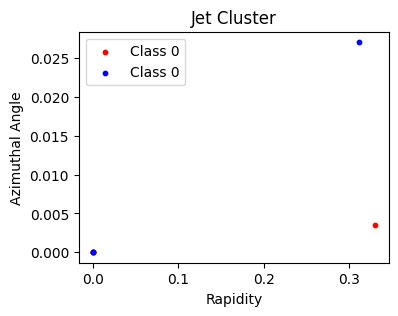

In [109]:
i=0
j=1
M = nodes_per_graph
fig = plt.figure(figsize=(4,3))
plt.scatter(x_data_proc[i,:,1],x_data_proc[i,:,2],c='r',s=10,label='Class '+str(y_data_proc[i].item()) ) #%(2*np.pi)
plt.scatter(x_data_proc[j,:,1],x_data_proc[j,:,2],c='b',s=10,label='Class '+str(y_data_proc[j].item()) ) #%(2*np.pi)
plt.title('Jet Cluster')
plt.xlabel('Rapidity')
plt.ylabel('Azimuthal Angle')
plt.legend()

In [110]:
i = 0
pos = {j: (x_data_proc[i,j,1]%(2*np.pi), x_data_proc[i,j,2]%(2*np.pi)) for j in range(M)}
make_jet_edges = [ (i,j) for i in pos for j in pos if i<j ]

In [111]:
# number of qubits
qubit_number = nodes_per_graph # M*2
qubits = range(qubit_number)

In [112]:
print(qubit_number)

3


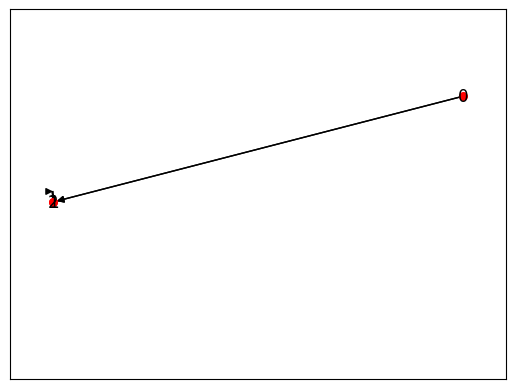

In [113]:
ising_graph = nx.DiGraph()
ising_graph.add_nodes_from(pos)
ising_graph.add_edges_from(make_jet_edges)
nx.draw_networkx(ising_graph, pos, node_color='red', node_size=30,edgelist=make_jet_edges)

In [114]:
term_dictionary = {0: [np.identity(2),np.identity(2)], 1: [qml.matrix(qml.PauliZ)(0), qml.matrix(qml.PauliZ)(0)]}

In [115]:
graph = dataset[0]

In [116]:
graph.edge_index.shape

torch.Size([2, 4])

In [117]:
reg1 = copy.copy([i for i in range(nodes_per_graph) ])
qubit_number

3

In [118]:
def state_evolve(hamiltonian, qubits, eta, q):
    U = torch.linalg.matrix_exp(-1j * eta * hamiltonian).cfloat()
    U = q@U@q.T.conj()
    qml.QubitUnitary(U, wires=qubits)

def qgcnn(inputs,weights):
    # ham_matrix1, ham_matrix2, tham_matrix1, tham_matrix2 = form_hamiltonians(graph1 = graphs[0], graph2 = graphs[1])
    # Prepares the low energy state in the two registers
    embedding_features = int(2**qubit_number)
    low_energy_state = inputs[1,:embedding_features]
    constant = torch.tensor([1.]).cfloat().to(device)
    qml.QubitStateVector(torch.kron(low_energy_state,constant), wires=reg1)
    # Evolves the first qubit register with the time-evolution circuit to
    # prepare a piece of quantum data
    inputs = inputs[0,:].reshape(batch_size,2,embedding_features,embedding_features)
    if batch_size==1:
        inputs = inputs.reshape(2,embedding_features,embedding_features)
        coeffs = weights[:,:int(n_layers*2)].reshape(n_layers,2)
        As = weights[:,int(n_layers*2):].reshape(n_layers,2,embedding_features,embedding_features)

    for j in range(coeffs.shape[0]):
      A = As[j,0,:,:].cfloat() + 1j*As[j,1,:,:].cfloat()
      I = torch.eye(A.shape[0],dtype = torch.cfloat).to(device)
      A = A + A.T.conj()
      q = (A - 1j*I)@torch.linalg.inv(A + 1j*I)
      if batch_size==1:
          state_evolve(inputs[0,:,:],  reg1, coeffs[j,0], q )
          state_evolve(inputs[1,:,:],  reg1, coeffs[j,1], q )
      else:
          state_evolve(inputs[:,0,:,:],  reg1, coeffs[j,0], q )
          state_evolve(inputs[:,1,:,:],  reg1, coeffs[j,1], q )
    return [qml.state()]

# Define a custom complex activation function (nn.Module)
class complex_activation(nn.Module):
    def forward(self, x):
        return nn.ReLU()(x.real) + 1.j * nn.ReLU()(x.imag)

qgcnn_dev = qml.device('default.qubit', wires=qubit_number)#, shots=shots)
# Defines the new QNode
qgcnn_qnode = qml.QNode(qgcnn,
                        device=qgcnn_dev,
                        interface = 'torch', #,#interface='torch', #interface = 'autograd'
                        diff_method='backprop')

class eigs_fn_torch(nn.Module):
    def forward(self, inputs, qstates_comp_basis):
        # Compute rotation matrices and eigenvalues
        qstates_comp_basis = qstates_comp_basis.flatten().cfloat()
        qstates_density_matrix =  qstates_comp_basis@qstates_comp_basis.T
        q,r = torch.linalg.qr(qstates_density_matrix)
        coupling_ham = (inputs[0].reshape(2,int(2**nodes_per_graph),int(2**nodes_per_graph)) )[0,:,:].cfloat()
        rotUC1 = q @ torch.linalg.matrix_exp( -1j * coupling_ham )
        UC1eigs = torch.linalg.eigvals(rotUC1)
        return qstates_comp_basis.reshape(1,qstates_comp_basis.shape[0]) #UC1eigs.reshape(1,UC1eigs.shape[0])

class product_state(nn.Module):
    def forward(self, qstates_comp_basis):
        qstates_comp_basis = qstates_comp_basis.flatten().cfloat()
        return qstates_comp_basis.reshape(1,qstates_comp_basis.shape[0])

class construct_low_energy_state(nn.Module):
    def forward(self, encoded_state):
        term = torch.tensor([1.]).cfloat().to(device)
        for i in range(encoded_state.shape[0]):
            term = torch.kron(encoded_state[i,:],term)
        normalize_factor = torch.sqrt(torch.abs(torch.conj(term)@term))
        term = term/normalize_factor
        return term

In [119]:
def state_evolve(hamiltonian, qubits, eta, q):
    U = torch.linalg.matrix_exp(-1j * eta * hamiltonian).cfloat()
    U = q@U@q.T.conj()
    qml.QubitUnitary(U, wires=qubits)

def qgcnn(inputs,weights):
    # ham_matrix1, ham_matrix2, tham_matrix1, tham_matrix2 = form_hamiltonians(graph1 = graphs[0], graph2 = graphs[1])
    # Prepares the low energy state in the two registers
    embedding_features = int(2**qubit_number)
    low_energy_state = inputs[1,:embedding_features]
    constant = torch.tensor([1.]).cfloat().to(device)
    qml.QubitStateVector(torch.kron(low_energy_state,constant), wires=reg1)
    # Evolves the first qubit register with the time-evolution circuit to
    # prepare a piece of quantum data
    inputs = inputs[0,:].reshape(batch_size,2,embedding_features,embedding_features)
    if batch_size==1:
        inputs = inputs.reshape(2,embedding_features,embedding_features)
        coeffs = weights[:,:int(n_layers*2)].reshape(n_layers,2)
        As = weights[:,int(n_layers*2):].reshape(n_layers,2,embedding_features,embedding_features)

    for j in range(coeffs.shape[0]):
      A = As[j,0,:,:].cfloat() + 1j*As[j,1,:,:].cfloat()
      I = torch.eye(A.shape[0],dtype = torch.cfloat).to(device)
      A = A + A.T.conj()
      q = (A - 1j*I)@torch.linalg.inv(A + 1j*I)
      if batch_size==1:
          state_evolve(inputs[0,:,:],  reg1, coeffs[j,0], q )
          state_evolve(inputs[1,:,:],  reg1, coeffs[j,1], q )
      else:
          state_evolve(inputs[:,0,:,:],  reg1, coeffs[j,0], q )
          state_evolve(inputs[:,1,:,:],  reg1, coeffs[j,1], q )
    return [qml.state()]

# Define a custom complex activation function (nn.Module)
class complex_activation(nn.Module):
    def forward(self, x):
        return nn.ReLU()(x.real) + 1.j * nn.ReLU()(x.imag)

qgcnn_dev = qml.device('default.qubit', wires=qubit_number)#, shots=shots)
# Defines the new QNode
qgcnn_qnode = qml.QNode(qgcnn,
                        device=qgcnn_dev,
                        interface = 'torch', #,#interface='torch', #interface = 'autograd'
                        diff_method='backprop')

class eigs_fn_torch(nn.Module):
    def forward(self, inputs, qstates_comp_basis):
        # Compute rotation matrices and eigenvalues
        qstates_comp_basis = qstates_comp_basis.flatten().cfloat()
        qstates_density_matrix =  qstates_comp_basis@qstates_comp_basis.T
        q,r = torch.linalg.qr(qstates_density_matrix)
        coupling_ham = (inputs[0].reshape(2,int(2**nodes_per_graph),int(2**nodes_per_graph)) )[0,:,:].cfloat()
        rotUC1 = q @ torch.linalg.matrix_exp( -1j * coupling_ham )
        UC1eigs = torch.linalg.eigvals(rotUC1)
        return qstates_comp_basis.reshape(1,qstates_comp_basis.shape[0]) #UC1eigs.reshape(1,UC1eigs.shape[0])

class product_state(nn.Module):
    def forward(self, qstates_comp_basis):
        qstates_comp_basis = qstates_comp_basis.flatten().cfloat()
        return qstates_comp_basis.reshape(1,qstates_comp_basis.shape[0])

class construct_low_energy_state(nn.Module):
    def forward(self, encoded_state):
        term = torch.tensor([1.]).cfloat().to(device)
        for i in range(encoded_state.shape[0]):
            term = torch.kron(encoded_state[i,:],term)
        normalize_factor = torch.sqrt(torch.abs(torch.conj(term)@term))
        term = term/normalize_factor
        return term

In [121]:
class quantum_iso_model(torch.nn.Module):
    def __init__(self, weight_shapes):
        super().__init__()
        # self.weights = torch.nn.Parameter(torch.randn(n_layers, gamma_and_eta))
        # self.transform = torch.nn.Identity()
        self.encoder = nn.Sequential( nn.Linear(x_data_proc.shape[2], 16, dtype=torch.cfloat),
                                      complex_activation(),
                                      nn.Linear(16, 16, dtype=torch.cfloat),
                                      complex_activation(),
                                      nn.Linear(16, 2, dtype=torch.cfloat) )

        self.qlayer = qml.qnn.TorchLayer(qgcnn_qnode, weight_shapes)
        self.eigs   = eigs_fn_torch()
        self.product_state = product_state()
        # self.eigenvalue_decomposition = eigenvalue_decomposition()
        # self.qr_decomposition = qr_decomposition()
        self.state  = construct_low_energy_state()

        self.decoder = nn.Sequential( nn.Linear(1, 6*2**qubit_number, dtype=torch.cfloat),
                                      complex_activation(),
                                      nn.Linear(6*2**qubit_number, 4*2**qubit_number, dtype=torch.cfloat),
                                      complex_activation(),
                                      nn.Linear(4*2**qubit_number, 2, dtype=torch.cfloat) )

    def forward(self, inputs, features):
        embedding = self.encoder(features)
        initial_state = self.state(embedding)
        initial_state = nn.functional.pad(initial_state, (0,inputs.shape[1]-initial_state.shape[0]), mode='constant', value=0)
        x = self.qlayer(torch.vstack([inputs,initial_state]))
        x = self.product_state(x).sum(axis=1)/x.shape[1] # sum provides permutation equivariance
        x = x.reshape(1,1)
        # x = self.eigenvalue_decomposition(x)
        # x = self.qr_decomposition(x)
        h = self.decoder(x)
        return (h*h.conj()).real

In [122]:
def quantum_training(train_dataloader,
                     val_dataloader,
                     epochs,
                     loss_fn,
                     model,
                     optimizer):

    size = len(train_dataloader)
    history = { 'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}

    best_train_loss = torch.inf
    best_val_loss = torch.inf
    best_model = None
    best_train_acc = 0.
    best_val_acc = 0.
    best_auc = 0.
    best_epoch = 0
    count = 0
    current_val_loss = 0
    best_auc = 0
    size_val = len(val_dataloader)
    first_idx = torch.arange(0,size_val)
    start = time()
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, _ , _ = train(model, optimizer, epoch, train_dataloader, backprop=True)
        val_loss, val_acc, val_label, val_pred = train(model, optimizer, epoch, val_dataloader, backprop=False)

        y_score = val_pred[(first_idx,val_label.astype('int32'))]
        auc_score = roc_auc_score(val_label, y_score)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print('\n')

        if val_loss <= best_val_loss:
          best_train_loss = train_loss
          best_val_loss = val_loss
          best_train_acc = train_acc
          best_val_acc = val_acc

        if best_auc <= auc_score and epoch>=15:
          # best_model = copy.deepcopy(model)
          # best_model_wts = copy.deepcopy(model.state_dict())
          best_auc = auc_score
          print(f'Rerun and stop at epoch {epoch} to attain the best classifier.')

          # best_model = copy.deepcopy(model)
          # best_model_wts = copy.deepcopy(model.state_dict())
          # if current_val_loss>best_val_loss:
          #   count=0
          # if count==0:
          #   best_auc = auc_score
          #   current_val_loss = best_val_loss
          #   count+=1



        if epoch % 1 == 0 or epoch==epochs-1: #args.test_interval == 0:
          print("Epoch: %d |  Best Train Loss: %.8f | Best Val Loss: %.8f | Best Train Acc: %.8f | Best Val Acc: %.8f" % (epoch, best_train_loss, best_val_loss, best_train_acc, best_val_acc))
          print('Epoch: %d |  VAL AUC: %.8f \n' % (epoch, auc_score))

    end = time()
    print(f'Training Complete. Total Time (s): {end-start}')
    return {'model': best_model, 'history': history}


def train(model, optimizer, epoch, loader, backprop=True):
    size = len(loader)
    num_correct = 0
    running_loss = 0.
    loss_list = []
    if backprop:
        model.train()
    else:
        model.eval()
    all_labels = np.zeros((size,))
    all_labels_pred = np.zeros((size,2))
    for batch_idx, data in enumerate(loader):
        if batch_idx==0:
            node_size, n_feat = data[0].x.size()
        batch_size = data.x.shape[0]//node_size
        inputs = data.pos.reshape(1,128).to(device)#(bacth_size,2*int(2**node_size)*int(2**node_size)).to(device)
        initial_node_features = data.x.cfloat().to(device)
        # labels = data.y.long().reshape(batch_size,).to(device)
        labels = data.y.long().reshape(1,).to(device)

        labels_pred = model(inputs,initial_node_features)
        loss = loss_fn(labels_pred,labels)
        loss_list.append(loss.item())
        optimizer.zero_grad()
        if backprop:
            loss.backward()
            optimizer.step()
        else:
          all_labels[batch_idx] = labels
          all_labels_pred[batch_idx] = labels_pred.detach().cpu()
        num_correct += (labels_pred.argmax(dim=1)==labels).sum().int()
        running_loss += loss.item()*batch_size

    accuracy = num_correct / size
    running_loss = running_loss/size

    return running_loss, accuracy, all_labels, all_labels_pred

In [123]:
seed = 3
torch.manual_seed(seed)
epochs = 16
embedding_size = 2**qubit_number
n_layers = 6
matrix_params =  n_layers*embedding_size*embedding_size*2
weight_shapes = {"weights": (1, n_layers*2 + matrix_params)}
model = quantum_iso_model(weight_shapes).to(device)
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()

In [124]:
count = 0
for i,param in enumerate(model.parameters()):
    if param.dtype==torch.complex64:
        count+=torch.view_as_real(param).flatten().shape[0]
    else:
        count+=param.flatten().shape[0]

In [125]:
print(count)

5012


In [126]:
len(train_quantum_dataloader)

80

In [127]:
qgnn_model_and_history = quantum_training(train_quantum_dataloader,
                             val_quantum_dataloader,
                             epochs,
                             loss_fn,
                             model,
                             optimizer)

  6%|▋         | 1/16 [00:09<02:15,  9.03s/it]



Epoch: 0 |  Best Train Loss: 0.63644302 | Best Val Loss: 0.69251286 | Best Train Acc: 0.43750000 | Best Val Acc: 0.50000000
Epoch: 0 |  VAL AUC: 1.00000000 



 12%|█▎        | 2/16 [00:18<02:10,  9.30s/it]



Epoch: 1 |  Best Train Loss: 0.63644302 | Best Val Loss: 0.69251286 | Best Train Acc: 0.43750000 | Best Val Acc: 0.50000000
Epoch: 1 |  VAL AUC: 0.95833333 



 19%|█▉        | 3/16 [00:27<01:56,  8.94s/it]



Epoch: 2 |  Best Train Loss: 0.63644302 | Best Val Loss: 0.69251286 | Best Train Acc: 0.43750000 | Best Val Acc: 0.50000000
Epoch: 2 |  VAL AUC: 0.29166667 



 25%|██▌       | 4/16 [00:35<01:47,  8.94s/it]



Epoch: 3 |  Best Train Loss: 0.63644302 | Best Val Loss: 0.69251286 | Best Train Acc: 0.43750000 | Best Val Acc: 0.50000000
Epoch: 3 |  VAL AUC: 0.12500000 



 31%|███▏      | 5/16 [00:44<01:35,  8.69s/it]



Epoch: 4 |  Best Train Loss: 0.63644302 | Best Val Loss: 0.69251286 | Best Train Acc: 0.43750000 | Best Val Acc: 0.50000000
Epoch: 4 |  VAL AUC: 0.54166667 



 38%|███▊      | 6/16 [00:52<01:25,  8.51s/it]



Epoch: 5 |  Best Train Loss: 0.63644302 | Best Val Loss: 0.69251286 | Best Train Acc: 0.43750000 | Best Val Acc: 0.50000000
Epoch: 5 |  VAL AUC: 0.75000000 



 44%|████▍     | 7/16 [01:00<01:15,  8.41s/it]



Epoch: 6 |  Best Train Loss: 0.63644302 | Best Val Loss: 0.69251286 | Best Train Acc: 0.43750000 | Best Val Acc: 0.50000000
Epoch: 6 |  VAL AUC: 0.58333333 



 50%|█████     | 8/16 [01:09<01:08,  8.58s/it]



Epoch: 7 |  Best Train Loss: 0.63644302 | Best Val Loss: 0.69251286 | Best Train Acc: 0.43750000 | Best Val Acc: 0.50000000
Epoch: 7 |  VAL AUC: 0.45833333 



 56%|█████▋    | 9/16 [01:18<01:00,  8.63s/it]



Epoch: 8 |  Best Train Loss: 0.63644302 | Best Val Loss: 0.69251286 | Best Train Acc: 0.43750000 | Best Val Acc: 0.50000000
Epoch: 8 |  VAL AUC: 0.00000000 



 62%|██████▎   | 10/16 [01:27<00:52,  8.68s/it]



Epoch: 9 |  Best Train Loss: 0.63469445 | Best Val Loss: 0.69121814 | Best Train Acc: 0.52500000 | Best Val Acc: 0.60000000
Epoch: 9 |  VAL AUC: 1.00000000 



 69%|██████▉   | 11/16 [01:35<00:42,  8.58s/it]



Epoch: 10 |  Best Train Loss: 0.63469445 | Best Val Loss: 0.69121814 | Best Train Acc: 0.52500000 | Best Val Acc: 0.60000000
Epoch: 10 |  VAL AUC: 0.08333333 



 75%|███████▌  | 12/16 [01:43<00:33,  8.43s/it]



Epoch: 11 |  Best Train Loss: 0.63469445 | Best Val Loss: 0.69121814 | Best Train Acc: 0.52500000 | Best Val Acc: 0.60000000
Epoch: 11 |  VAL AUC: 0.58333333 



 81%|████████▏ | 13/16 [01:51<00:25,  8.36s/it]



Epoch: 12 |  Best Train Loss: 0.63469445 | Best Val Loss: 0.69121814 | Best Train Acc: 0.52500000 | Best Val Acc: 0.60000000
Epoch: 12 |  VAL AUC: 0.83333333 



 88%|████████▊ | 14/16 [01:59<00:16,  8.30s/it]



Epoch: 13 |  Best Train Loss: 0.63469445 | Best Val Loss: 0.69121814 | Best Train Acc: 0.52500000 | Best Val Acc: 0.60000000
Epoch: 13 |  VAL AUC: 1.00000000 



 94%|█████████▍| 15/16 [02:07<00:08,  8.24s/it]



Epoch: 14 |  Best Train Loss: 0.63469445 | Best Val Loss: 0.69121814 | Best Train Acc: 0.52500000 | Best Val Acc: 0.60000000
Epoch: 14 |  VAL AUC: 0.00000000 



100%|██████████| 16/16 [02:16<00:00,  8.55s/it]



Rerun and stop at epoch 15 to attain the best classifier.
Epoch: 15 |  Best Train Loss: 0.63469445 | Best Val Loss: 0.69121814 | Best Train Acc: 0.52500000 | Best Val Acc: 0.60000000
Epoch: 15 |  VAL AUC: 0.45833333 

Training Complete. Total Time (s): 136.81393671035767


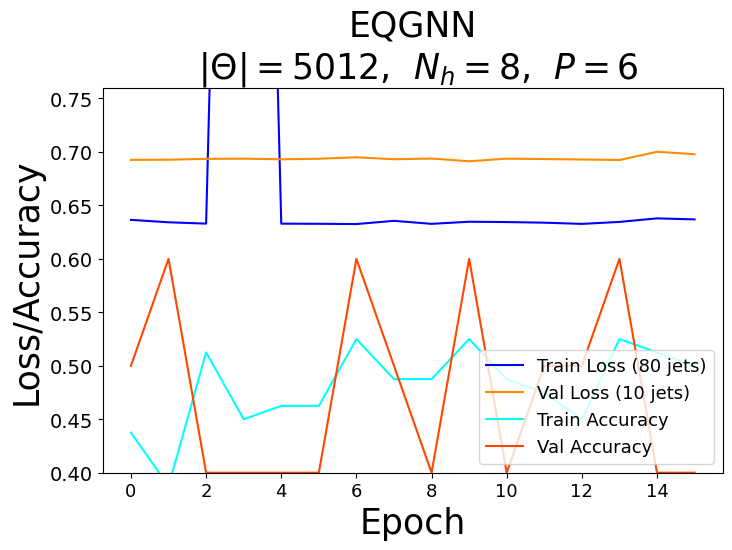

In [129]:
train_acc = []
for i,val in enumerate(qgnn_model_and_history['history']['train_acc']):
    train_acc.append(val.cpu().detach().numpy())

val_acc = []
for i,val in enumerate(qgnn_model_and_history['history']['val_acc']):
    val_acc.append(val.cpu().detach().numpy())

plt.figure(figsize=(8,5))
plt.plot(qgnn_model_and_history['history']['train_loss'],c='b',label=f'Train Loss ({train_index} jets)')
plt.plot(qgnn_model_and_history['history']['val_loss'],c='darkorange',label=f'Val Loss ({val_index-train_index} jets)')
plt.plot(train_acc,c='cyan',label='Train Accuracy')
plt.plot(val_acc,c='orangered',label='Val Accuracy')
plt.title(f'EQGNN\n $|\Theta| = {count}$,  $N_h={embedding_size}$,  $P={n_layers}$', fontsize=25)
plt.xlabel('Epoch',fontsize=25)
plt.ylabel('Loss/Accuracy',fontsize=25)
plt.legend(fontsize = 13, loc = 'lower right')
plt.xticks(fontsize=13,ticks=[i for i in range(0,epochs,2)])
plt.yticks(fontsize=14)
plt.ylim([0.40,0.76])
plt.savefig(plot_path+f'eqgnn_training_{count}_{embedding_size}_{n_layers}_{seed}.png',bbox_inches='tight')